<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/28_NLP_Basics_and_Embeddings/28_Word2Vec/28_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Word2Vec Implementation with 20-Newsgroups Dataset**

### What is Word2Vec?
Word2Vec is a way to represent words as numbers (vectors) so that a computer can understand relationships b/w words. Instead of treating words as isolated, it captures meanings like:
- "king" is close to "queen"
- "dog" is close to "cat"
- "Paris" is related to "France"

It does this by looking at the context (neighboring words).

For example: "The cat sat on the mat", "cat" often appears near "mat" → so they are related.

### **Skip-gram approach**: Predict surrounding words (context) given one target word.
### **Negative Sampling**: Add fake pairs (random words) so model learns to distinguish b/w true and false neighbors.

## **Install needed libraries**

In [29]:
!pip install -q tqdm scikit-learn matplotlib

In [30]:
import io
import re
import string
import numpy as np
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dot, Flatten, TextVectorization

## **Load Dataset**

In [31]:
# We use the 20-Newsgroups dataset (a collection of online forum posts).
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data[:5000] # use first 5000 docs to keep training fast

## **Prepare Dataset**

In [32]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

In [33]:
vocab_size = 5000 # keep 5000 most frequent words
sequence_length = 10 # each sentence will be trimmed/padded to length 10

vectorize_layer = TextVectorization(standardize=custom_standardization, max_tokens=vocab_size,
                                    output_mode='int', output_sequence_length=sequence_length)

text_ds = tf.data.Dataset.from_tensor_slices(texts).batch(1024)
vectorize_layer.adapt(text_ds)

In [34]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab)

['', '[UNK]', np.str_('the'), np.str_('to'), np.str_('of'), np.str_('and'), np.str_('a'), np.str_('in'), np.str_('is'), np.str_('i'), np.str_('that'), np.str_('it'), np.str_('for'), np.str_('you'), np.str_('this'), np.str_('on'), np.str_('be'), np.str_('are'), np.str_('have'), np.str_('with'), np.str_('not'), np.str_('as'), np.str_('or'), np.str_('if'), np.str_('but'), np.str_('was'), np.str_('they'), np.str_('by'), np.str_('from'), np.str_('at'), np.str_('an'), np.str_('can'), np.str_('will'), np.str_('all'), np.str_('my'), np.str_('would'), np.str_('what'), np.str_('one'), np.str_('we'), np.str_('there'), np.str_('do'), np.str_('about'), np.str_('so'), np.str_('x'), np.str_('has'), np.str_('your'), np.str_('he'), np.str_('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax'), np.str_('some'), np.str_('no'), np.str_('any'), np.str_('which'), np.str_('1'), np.str_('me'), np.str_('who'), np.str_('were'), np.str_('its'), np.str_('out'), np.str_('people'), np.str_('their'), np.str_('more'), np.str_('when'), 

In [35]:
text_vector_ds = text_ds.map(vectorize_layer).unbatch()
sequences = list(text_vector_ds.as_numpy_iterator())
print(sequences)

[array([   9,   25, 1159,   23,  129,   57,   39,   86,    1,   53]), array([   6, 1322,  161,    4,    1,    1,   54,    1,   59, 2242]), array([  85, 1122,   34,  545,  748,  923,  834,   69,    2,    1]), array([ 40,  13,  18,   1,   1, 161, 225,  63,   3,  68]), array([  28,  354,    1,   27,    1, 1372,    6,    1,   34, 1190]), array([   4,  220,    2, 1111,  152,   16,    1, 1797,    7,   50]), array([  39,   55,    6,  196,   58,   54, 3130,    3,   34,  845]), array([  33,   14, 1222,    8,   10,   13,   66,   73,   98,   41]), array([   9,   18,  591,  400,    5,    1,  257, 4570,    5,    1]), array([149,  64,   2, 634,  12, 113,   6, 165,   5,  11]), array([  9,  18,   6, 243,  15,   6,   1,   1,   1, 657]), array([   1,  205,  408,   98,   11,   94,   20,    6, 2767,   24]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1547,    4, 1588, 2444, 1182,   12, 4689, 3630,  869,    1]), array([3033, 1934,    9,   18,    6,  202,    4,  163,    1,   15]), array([  66,   16,   42,

## **Generate Training Data**

In [36]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  targets, contexts, labels = [], [], []
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  for sequence in tqdm.tqdm(sequences):
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(sequence, vocabulary_size=vocab_size,
                                                                       sampling_table=sampling_table, window_size=window_size,
                                                                       negative_samples=0, seed=int(seed)) # Ensure seed is an integer

    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(true_classes=context_class, num_true=1,
                                                                                   num_sampled=num_ns, unique=True, range_max=vocab_size,
                                                                                   seed=seed, name="negative_sampling")
      negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)
      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      targets.append(target_word)
      contexts.append(context)
      labels.append(label)
  return targets, contexts, labels

In [37]:
# Generate skip-gram training examples
targets, contexts, labels = generate_training_data(sequences=sequences, window_size=2, num_ns=4, vocab_size=vocab_size, seed=SEED)

100%|██████████| 5000/5000 [00:34<00:00, 146.14it/s]


In [38]:
print(f"target  :", targets)
print(f"context :", contexts)
print(f"label   :", labels)

Streaming output truncated to the last 5000 lines.
       [   6],
       [  31],
       [  18]])>, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[539],
       [260],
       [159],
       [202],
       [ 78]])>, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[  41],
       [ 175],
       [   4],
       [   0],
       [2140]])>, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[  8],
       [ 58],
       [ 11],
       [  5],
       [190]])>, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[  11],
       [ 181],
       [1432],
       [   8],
       [   9]])>, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[  65],
       [ 356],
       [   0],
       [1679],
       [1130]])>, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 21],
       [  7],
       [  5],
       [990],
       [  0]])>, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 11],
       [ 77],
       [ 66],
       [  3],
       [827]])>, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([

In [39]:
print(f"target length:", len(targets))
print(f"context length:", len(contexts))
print(f"label length:", len(labels))

target length: 29275
context length: 29275
label length: 29275


## **Prepare Training Data**

In [40]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 5, 1), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [41]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 5, 1), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


## **Define Word2Vec Model**

In [42]:
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, embedding_dim, name="w2v_embedding")
    self.context_embedding = Embedding(vocab_size, embedding_dim)
    self.dots = Dot(axes=(2, 2))   # match last dim of both embeddings
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair  # target: (batch,), context: (batch, num_ns+1)
    # (batch, 1, emb_dim)
    we = self.target_embedding(target)
    we = tf.expand_dims(we, 1)  # add context axis → (batch, 1, emb_dim)
    # (batch, num_ns+1, emb_dim)
    ce = self.context_embedding(tf.squeeze(context, axis=-1))
    # Dot product → (batch, num_ns+1, 1)
    dots = self.dots([ce, we])
    return self.flatten(dots)   # (batch, num_ns+1)

## **Train the Model**

In [43]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Train model and capture history
history = word2vec.fit(dataset, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2281 - loss: 1.6087
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6666 - loss: 1.5922
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7584 - loss: 1.5620
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7264 - loss: 1.4954
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6920 - loss: 1.4053
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6813 - loss: 1.3215
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6917 - loss: 1.2450
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7117 - loss: 1.1722
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7342 - loss: 1.1023
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7530 - loss: 1.0355
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.9721
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

## **Plot Loss & Accuracy**

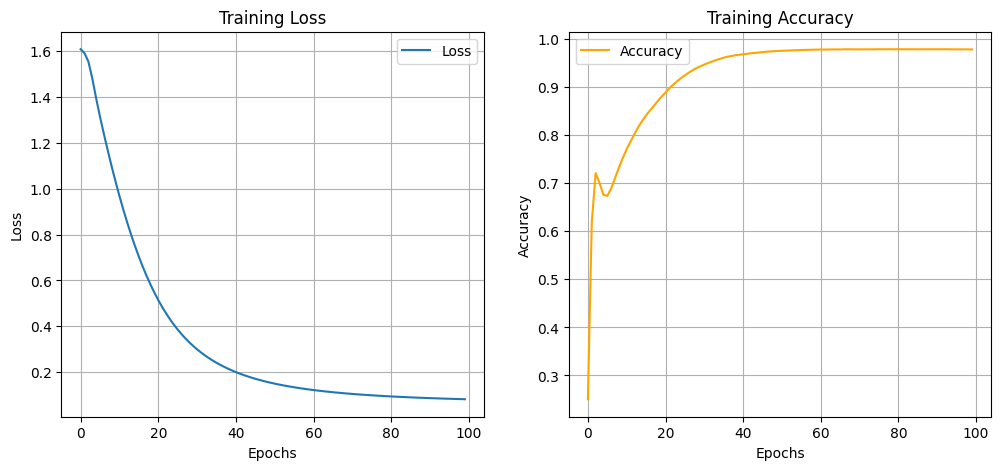

In [44]:
plt.figure(figsize=(12,5))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

## **Testing (find similar words)**

In [45]:
# After training, embeddings are stored in the target embedding layer.
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
# Helper function to get closest words to a given word
def find_similar(word, top_k=5):
  if word not in inverse_vocab:
    print(f"'{word}' not in vocabulary!")
    return
  word_index = inverse_vocab.index(word)
  word_vec = weights[word_index]

  # Compute cosine similarity with all words
  similarities = np.dot(weights, word_vec) / (np.linalg.norm(weights, axis=1) * np.linalg.norm(word_vec) + 1e-10)
  similar_indices = np.argsort(-similarities)[1:top_k+1]
  print(f"Words similar to '{word}':")
  for idx in similar_indices:
    print(f" {inverse_vocab[idx]} (score: {similarities[idx]:.4f})")

In [46]:
find_similar('computer')

Words similar to 'computer':
 notes (score: 0.5017)
 attempts (score: 0.4848)
 lindros (score: 0.4320)
 imaging (score: 0.4131)
 re (score: 0.4128)


## **Embedding lookup and analysis**

In [48]:
# Save embeddings + metadata for visualization (e.g. TensorBoard projector)
out_v = io.open('Word2Vec_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('Word2Vec_metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(inverse_vocab):
  if index == 0: # skip 0, it's padding
    continue
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")


out_v.close()
out_m.close()
print("Embedding vectors saved to 'Word2Vec_vectors.tsv' and metadata to 'Word2Vec_metadata.tsv'.")

Embedding vectors saved to 'Word2Vec_vectors.tsv' and metadata to 'Word2Vec_metadata.tsv'.
